In [8]:

import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder




In [10]:
tv_ = pd.read_pickle("tv_show.pkl")

In [12]:
tv_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168639 entries, 0 to 168638
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        168639 non-null  int64         
 1   number_of_seasons         168639 non-null  int64         
 2   number_of_episodes        168639 non-null  int64         
 3   original_language         168639 non-null  int8          
 4   vote_count                168639 non-null  int64         
 5   vote_average              168639 non-null  float64       
 6   overview                  93333 non-null   string        
 7   adult                     168639 non-null  bool          
 8   first_air_date            136903 non-null  datetime64[ns]
 9   last_air_date             138735 non-null  datetime64[ns]
 10  in_production             168639 non-null  bool          
 11  popularity                168639 non-null  float64       
 12  ty

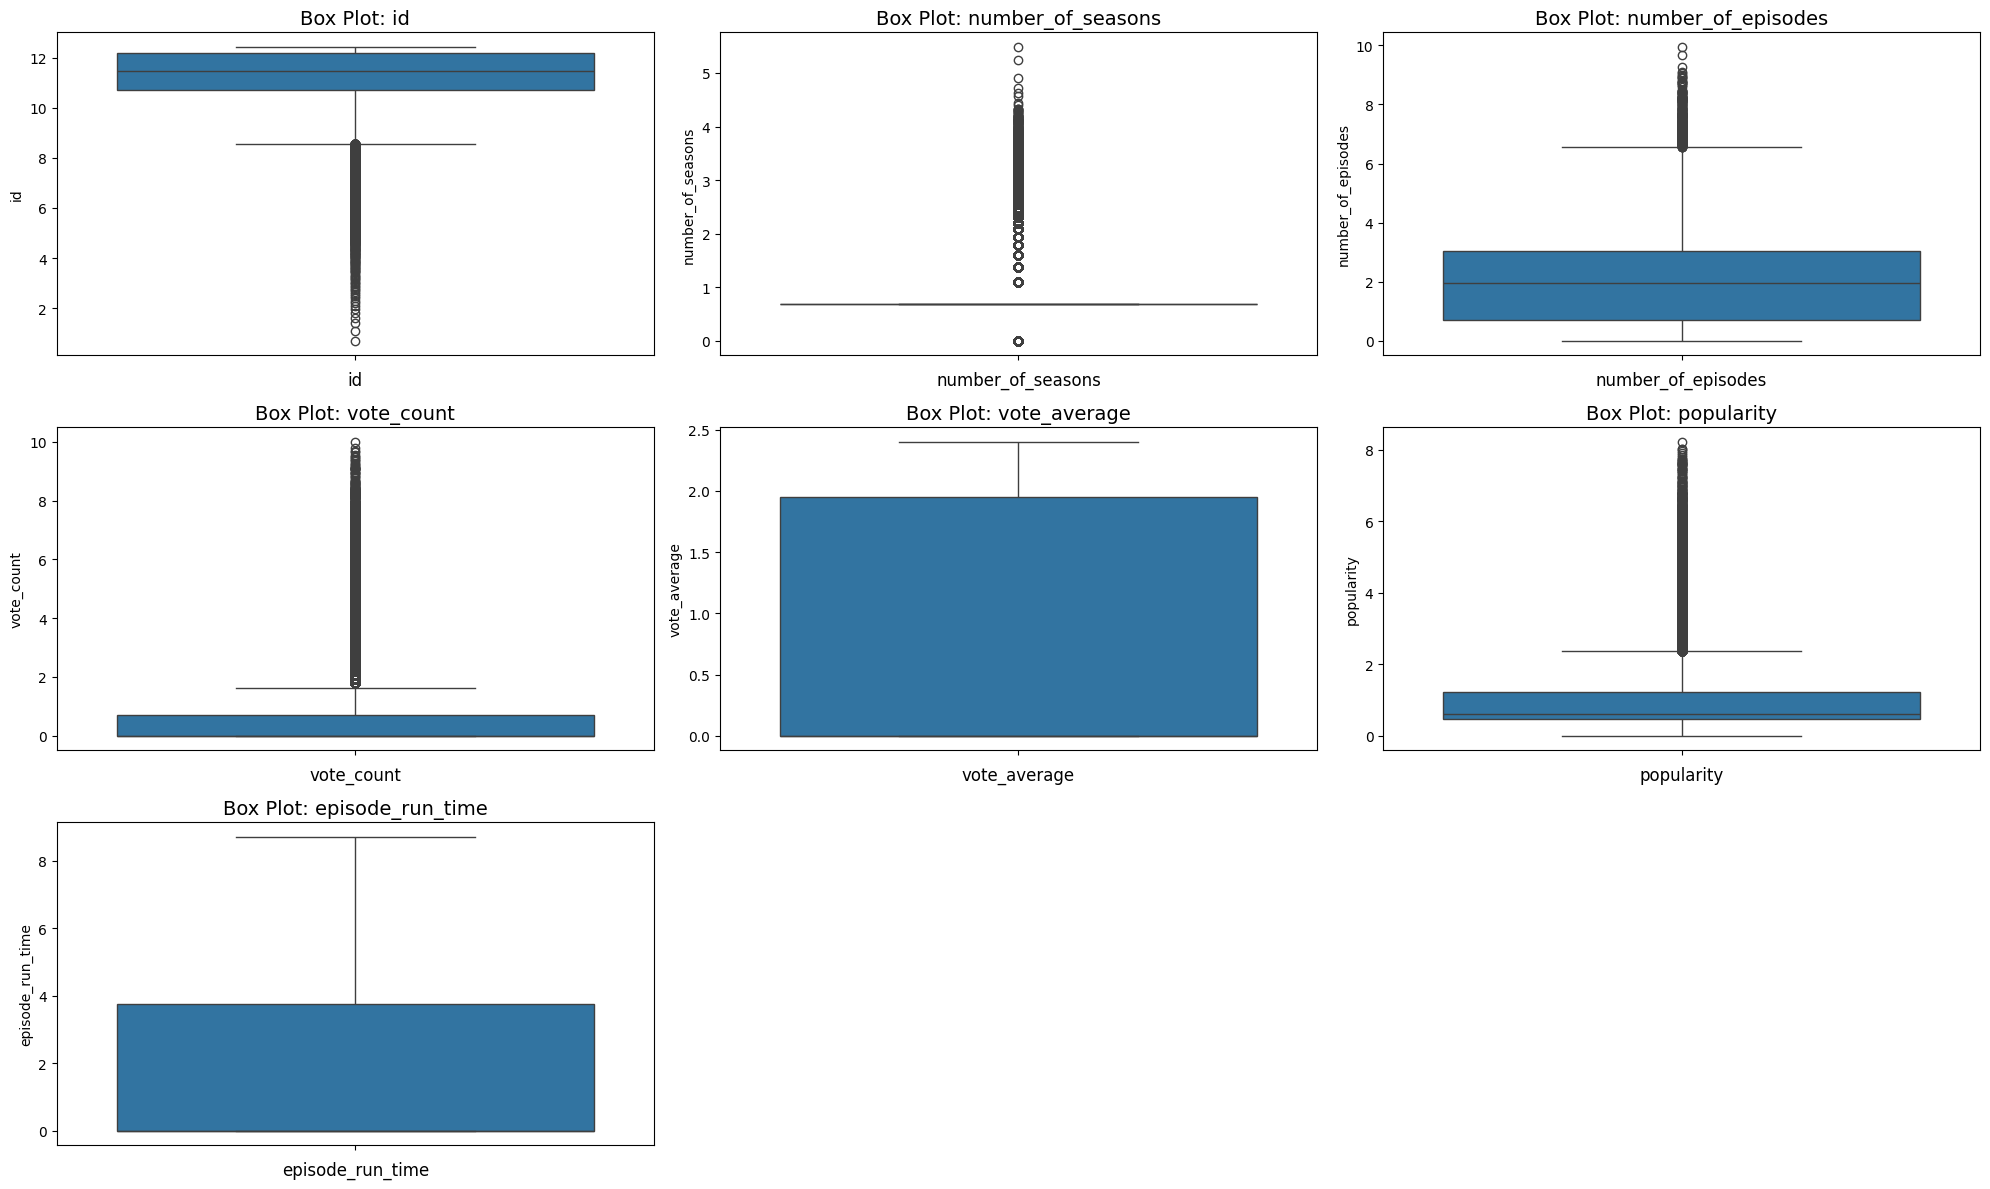

In [14]:

import math
tv_out = tv_[['id','number_of_seasons','number_of_episodes','vote_count','vote_average','popularity','episode_run_time']]

def outliers_boxplot(df):
    num_cols = len(df.columns)
    rows = math.ceil(num_cols / 3)  # Dynamically set rows for 3 columns
    plt.figure(figsize=(20, rows * 4))  # Adjust figure size

    for i, col in enumerate(df.columns):
        ax = plt.subplot(rows, 3, i + 1)

        sns.boxplot(data=np.log1p(df[col]), ax=ax)  # log(1+x) to avoid log(0) errors

        plt.title(f'Box Plot: {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)

    plt.tight_layout()  # Automatically adjusts spacing
    plt.show()

outliers_boxplot(tv_out)


In [42]:
import missingno as msno
from scipy.stats import zscore, ks_2samp

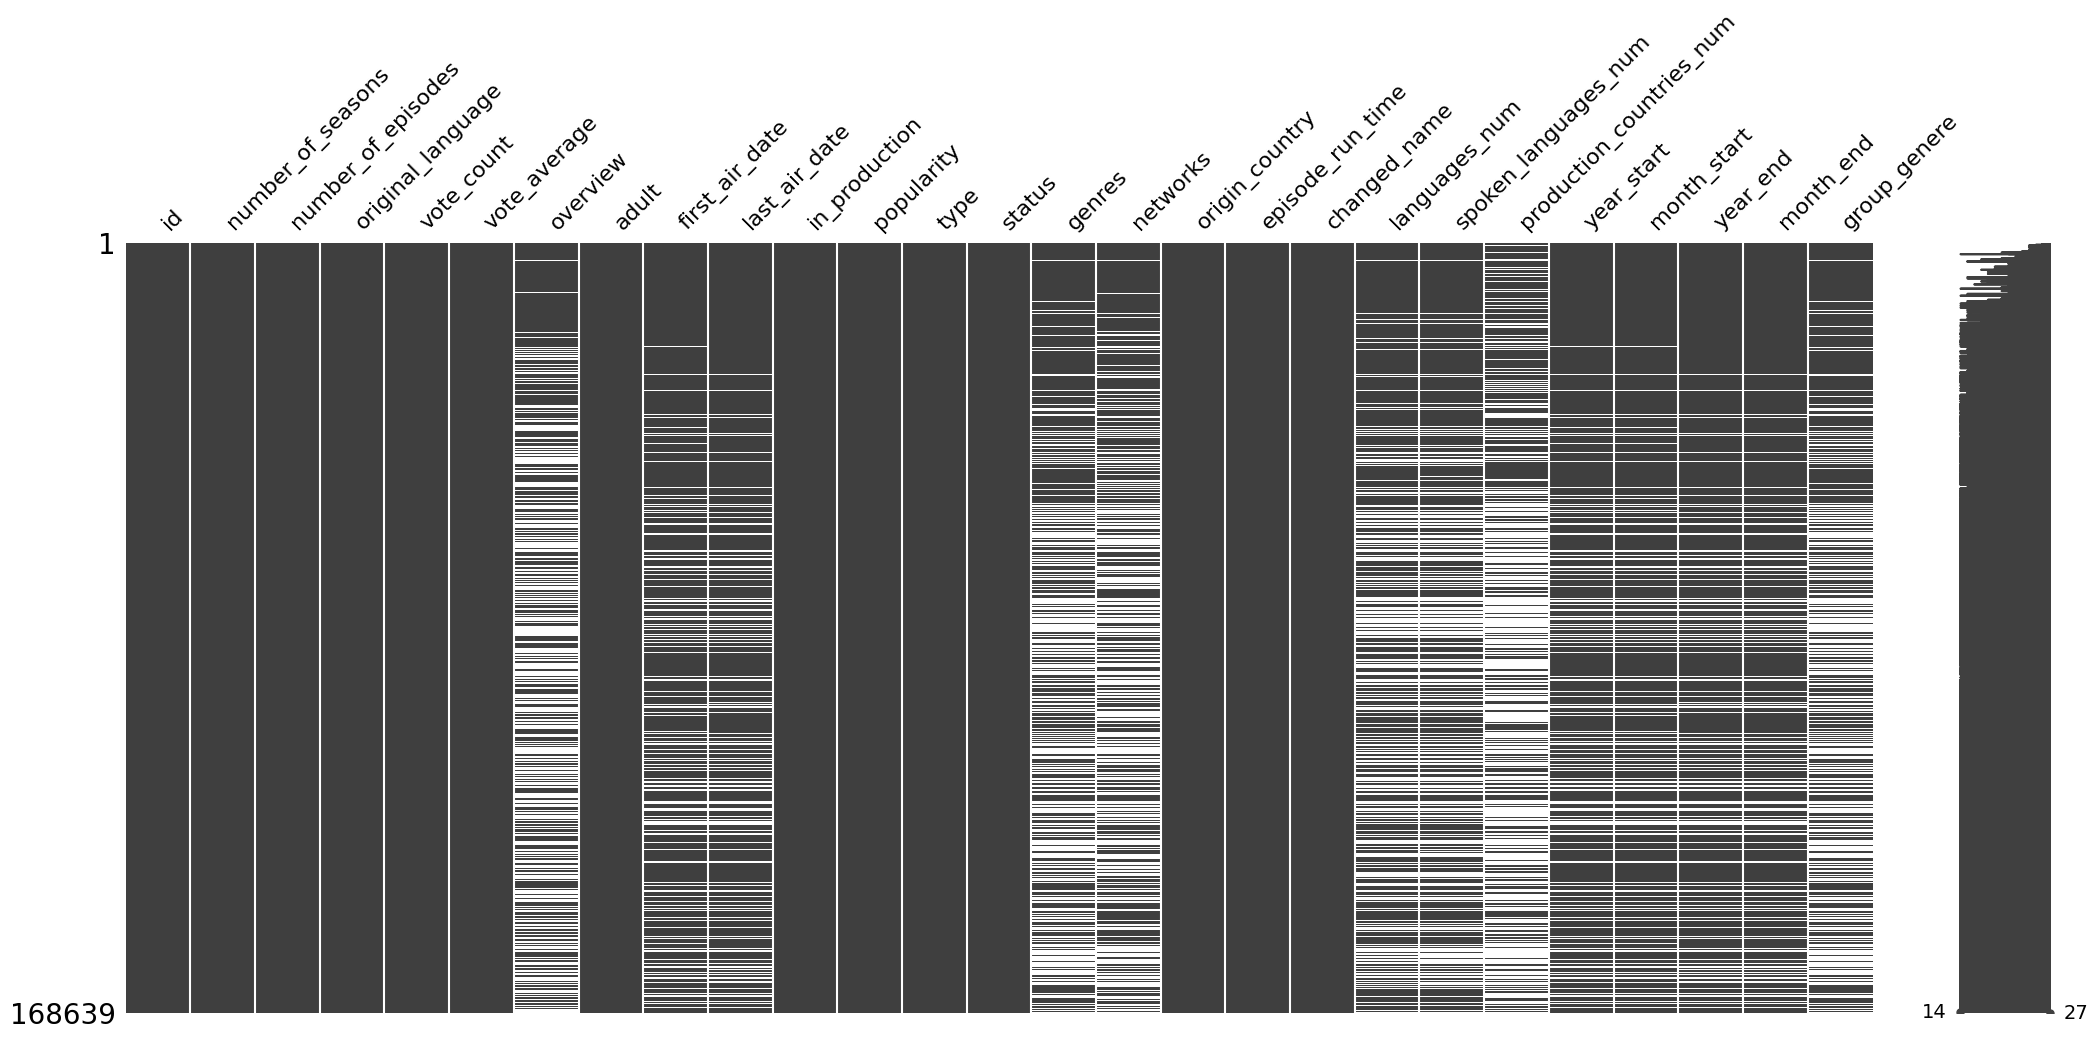

In [18]:
msno.matrix(tv_)
plt.show()

In [150]:
number_col = tv_.select_dtypes(include =[float,int])
number_col = number_col.drop(columns =['year_start','year_end','month_start','month_end'])
number_log = np.log1p(number_col)


In [152]:


# Function to identify and treat outliers using IQR
def treat_outliers(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)
    return df_outliers



In [154]:
outliers_tv = treat_outliers(tv_,number_log)
outliers_tv.head()


,id,number_of_seasons,number_of_episodes,vote_count,vote_average,popularity,episode_run_time,languages_num,spoken_languages_num,production_countries_num
0,0,1,1,1,0,1,0,0,0,1
1,0,1,0,1,0,1,0,0,0,0
2,0,1,0,1,0,1,0,0,0,0
3,0,1,1,1,0,1,0,0,0,0
4,0,1,1,1,0,1,0,0,0,0


In [160]:
#Creating a table for outliers change
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
out_df
k = number_log.columns.to_list()

In [162]:
k

['id',
 'number_of_seasons',
 'number_of_episodes',
 'vote_count',
 'vote_average',
 'popularity',
 'episode_run_time',
 'languages_num',
 'spoken_languages_num',
 'production_countries_num']

In [170]:
# Checking distribution and correlation changes
for col in number_log:
    out = tv_[col]
    non_out = tv_[col][outliers_tv[col] == 0]
    cor_out = tv_['popularity']
    cor_non_out = tv_['popularity'][outliers_tv[col] == 0]

    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)

    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] -
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'

    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    new_row = pd.DataFrame({'feature': [col],
                            'outliers_cnt': [outliers_tv[col].sum()],
                            'distribution_changed': [dist_change],
                            'correlation_changed': [cor_change]})

    out_df = pd.concat([out_df, new_row], ignore_index=True)

C:\Users\OMER\AppData\Local\pypoetry\Cache\virtualenvs\mlproject-Yj7xdwhQ-py3.10\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\OMER\AppData\Local\pypoetry\Cache\virtualenvs\mlproject-Yj7xdwhQ-py3.10\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [172]:
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed
0,id,0,-,-
1,number_of_seasons,54613,+,-
2,number_of_episodes,16793,+,+
3,vote_count,26221,+,+
4,vote_average,0,-,-
5,popularity,24368,+,-
6,episode_run_time,2868,+,-
7,languages_num,5175,+,-
8,spoken_languages_num,4463,+,-
9,production_countries_num,3277,+,-


In [174]:
# Filter outliers where 'popularity' is an outlier
pop_out = outliers_tv[outliers_tv['popularity'] == 1]
pop_out.head()

# Create an empty DataFrame to store results
pop_df = pd.DataFrame(columns=['feature', 'sum_out'])

# Loop through columns and count outliers
for col in pop_out.columns:
    new_row = pd.DataFrame({'feature': [col], 'sum_out': [pop_out[col].sum()]})
    pop_df = pd.concat([pop_df, new_row], ignore_index=True)  # Append new row

# Display result
pop_df


,feature,sum_out
0,id,0
1,number_of_seasons,10988
2,number_of_episodes,9908
3,vote_count,14571
4,vote_average,0
5,popularity,24368
6,episode_run_time,563
7,languages_num,1707
8,spoken_languages_num,1341
9,production_countries_num,1205


In [176]:
# Extract the number of outliers for popularity
popularity_outliers = out_df.loc[out_df['feature'] == 'popularity', 'outliers_cnt'].values[0]

# Compute the percentage of popularity outliers
popularity_outlier_percentage = popularity_outliers / len(tv_['popularity'])

# Print the result as an integer count and percentage
print(f"Total Popularity Outliers: {int(popularity_outliers)}")
print(f"Percentage of Popularity Outliers: {popularity_outlier_percentage:.2%}")


Total Popularity Outliers: 24368
Percentage of Popularity Outliers: 14.45%


In [95]:
# display the presentage popularity outlier as the total outlier per column 
for val in pop_df['feature'].unique().tolist():
    pop_val =pop_df[pop_df['feature']==val]['sum_out'].values[0]
    out_val = out_df[out_df['feature']==val]['outliers_cnt'].values[0]
    present = (pop_val/out_val) if out_val >0 else 0
    
    pop_df.loc[pop_df['feature'] == val, 'present_of_total'] = present


pop_df

C:\Users\OMER\AppData\Local\Temp\ipykernel_2968\2889816066.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20119751707468916' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_df.loc[pop_df['feature'] == val, 'present_of_total'] = present


,feature,sum_out,present_of_total
0,id,0,0.000000
1,number_of_seasons,10988,0.201198
2,number_of_episodes,9908,0.590008
3,vote_count,14571,0.555700
4,vote_average,0,0.000000
5,popularity,24368,1.000000
6,episode_run_time,563,0.196304
7,languages_num,1707,0.329855
8,spoken_languages_num,1341,0.300471
9,production_countries_num,1205,0.367714


Total Popularity Outliers: 24368
Percentage of Popularity Outliers: 14.45%


# Conclution:
## number_of_episodes & vote_count : should stay the same - no outlier removal
## The outlier columns values are very important for the high popularity values
### therefor there is no justification for removing them 
